# Сегментация изображений

В данной теме необходимо:
* Необходимо подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples для обучения модели на сегментацию губ
* Обучить модель на выбор из segmentation_models_pytorch

## Подключаем библиотеки

In [149]:
import os

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

import matplotlib.pyplot as plt

import segmentation_models_pytorch as smp

import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

## Объявим глобальные переменные

In [2]:
DATA_ROOT = './data/ImageSegmentation/set-lipstick-original'
IMGS_INPUT = []
IMGS_TARGET = []
BACKBONE = 'resnet34'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EPOCH = 1

## Опишем датасет

In [138]:
class LipsDataset(Dataset):
    def __init__(self, data, preprocessing=None):
        # Подаем наш подготовленный датафрейм
        self.data = data
        # Разделяем датафрейм на rgb картинки
        self.image_arr = self.data.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data.iloc[:,1]
        # Количество пар картинка-сегментация
        self.data_len = len(self.data.index)
        self.preprocessing = preprocessing


    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива
        # размера 256х256 float-значений
        img = cv2.cvtColor(cv2.imread(self.image_arr[index]), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))

        img = np.asarray(img).astype('float')

        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            # Нормализуем изображение в значениях [0, 1]
            img = torch.as_tensor(img) / 255.0
        img = img.permute(2,0,1)

        # считаем сегментированную картинку
        masks = []
        mask = cv2.cvtColor(cv2.imread(self.label_arr[index]), cv2.COLOR_BGR2GRAY)

        # генерация двух масок
        # фон
        cls_mask = np.where(mask == 0, 255, 0)
        cls_mask = cls_mask.astype('float')
        cls_mask = cv2.resize(cls_mask, (256, 256))

        masks.append(cls_mask[:,:] / 255)

        # маска
        cls_mask = np.where(mask != 0, 255, 0)
        cls_mask = cls_mask.astype('float')
        cls_mask = cv2.resize(cls_mask, (256, 256))

        masks.append(cls_mask[:,:] / 255)

        masks = torch.as_tensor(masks, dtype=torch.uint8)

        return img.float(), masks

    def __len__(self):
        return self.data_len

## Выполним подготовку изображений

In [150]:
# Загрузим полные пути до оригинальный изображений и масок
IMGS_INPUT = []
IMGS_TARGET = []
for root, dirs, files in os.walk(DATA_ROOT):
    for name in files:
        f = os.path.join(root, name)
        if '720p' in f:
            f_seg = f.replace('720p', 'mask')
            f_seg = f_seg.replace('image', 'mask')
            f_seg = f_seg.replace('jpg', 'png')
            if os.path.exists(f_seg):
                IMGS_INPUT.append(f)
                IMGS_TARGET.append(f_seg)
            else:
                print(f_seg)

./data/ImageSegmentation/set-lipstick-original\mask\mask00010716.png
./data/ImageSegmentation/set-lipstick-original\mask\mask00010717.png
./data/ImageSegmentation/set-lipstick-original\mask\mask00010718.png
./data/ImageSegmentation/set-lipstick-original\mask\mask00010719.png
./data/ImageSegmentation/set-lipstick-original\mask\mask00010721.png
./data/ImageSegmentation/set-lipstick-original\mask\mask00010722.png
./data/ImageSegmentation/set-lipstick-original\mask\mask00010724.png
./data/ImageSegmentation/set-lipstick-original\mask\mask00010730.png
./data/ImageSegmentation/set-lipstick-original\mask\mask00010732.png
./data/ImageSegmentation/set-lipstick-original\mask\mask00010733.png
./data/ImageSegmentation/set-lipstick-original\mask\mask00010735.png
./data/ImageSegmentation/set-lipstick-original\mask\mask00010736.png
./data/ImageSegmentation/set-lipstick-original\mask\mask00010737.png
./data/ImageSegmentation/set-lipstick-original\mask\mask00010740.png
./data/ImageSegmentation/set-lipst

In [151]:
# Создадим соотношение между оригинальными изображениями и масоками
df = pd.DataFrame({'IMGS_INPUT': IMGS_INPUT, 'IMGS_TARGET': IMGS_TARGET})
df.sort_values(by='IMGS_INPUT', inplace=True)

# т.к. удалили пустые поля, чтобы не засорять нейроную сеть и провели сортировку, сбрасываем индексы
df.reset_index(drop=True, inplace=True)
df.head(5)

,IMGS_INPUT,IMGS_TARGET
0,./data/ImageSegmentation/set-lipstick-original...,./data/ImageSegmentation/set-lipstick-original...
1,./data/ImageSegmentation/set-lipstick-original...,./data/ImageSegmentation/set-lipstick-original...
2,./data/ImageSegmentation/set-lipstick-original...,./data/ImageSegmentation/set-lipstick-original...
3,./data/ImageSegmentation/set-lipstick-original...,./data/ImageSegmentation/set-lipstick-original...
4,./data/ImageSegmentation/set-lipstick-original...,./data/ImageSegmentation/set-lipstick-original...


C:\Users\vlad\AppData\Local\Temp\ipykernel_15728\3144197804.py:56: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)


torch.Size([3, 256, 256]) torch.Size([2, 256, 256])


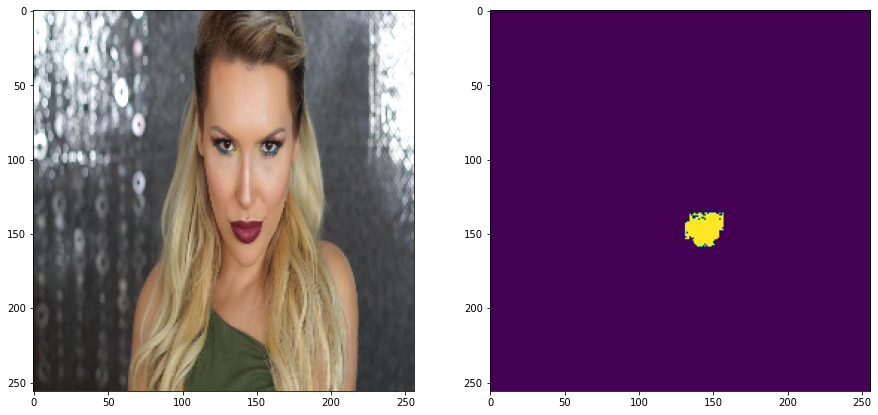

In [137]:
# Просто смотрим, что получилось и работает ли датасет
dataset = LipsDataset(df)

img, masks = dataset[0]
print(img.shape, masks.shape)
_, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(masks.permute(1, 2, 0)[..., 1])
plt.show()

## Обучаем модель из segmentation_models_pytorch

In [139]:
segmodel = smp.Linknet(BACKBONE, classes=2, activation='softmax').to(DEVICE)
preprocess_input = smp.encoders.get_preprocessing_fn(BACKBONE, pretrained='imagenet')

C:\Users\vlad\AppData\Local\Temp\ipykernel_15728\3144197804.py:56: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256]) torch.Size([2, 256, 256])


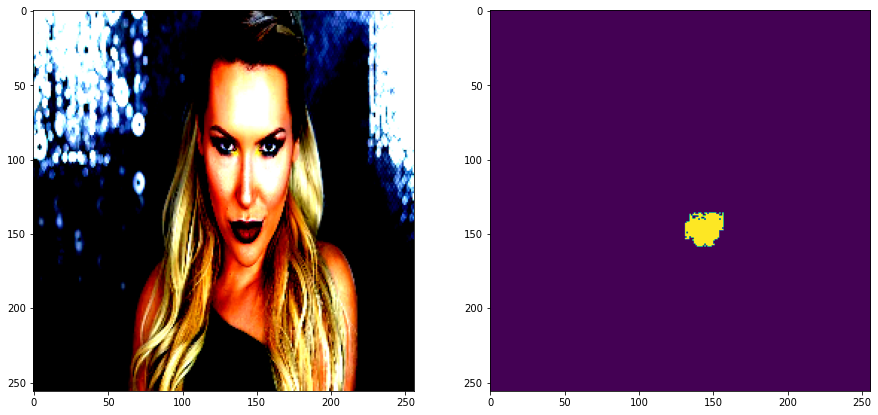

In [140]:
dataset = LipsDataset(df, preprocessing=preprocess_input)
img, mask = dataset[0]
print(img.shape, mask.shape)
_, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(mask.permute(1, 2, 0)[..., 1])
plt.show()



In [141]:
# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df, test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = LipsDataset(X_train,
                         preprocessing=preprocess_input)
test_data = LipsDataset(X_test,
                        preprocessing=preprocess_input)

In [142]:
train_dataloader = DataLoader(train_data, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=4)

In [143]:
loss_fn = smp.utils.losses.DiceLoss()
metric = [smp.utils.metrics.IoU(), ]

optimizer = Adam(params=segmodel.parameters(), lr=0.001)

In [144]:
train_epoch = smp.utils.train.TrainEpoch(segmodel, loss=loss_fn, metrics=metric, device=DEVICE, optimizer=optimizer, verbose=True)
test_epoch = smp.utils.train.ValidEpoch(segmodel, loss=loss_fn, metrics=metric, device=DEVICE, verbose=True)

In [145]:
max_score = 0
for i in range(0, EPOCH):
    print(f"Epoch: {i}")
    train_logs = train_epoch.run(train_dataloader)
    test_logs = test_epoch.run(test_dataloader)

    if max_score < test_logs['iou_score']:
        max_score = test_logs['iou_score']
        torch.save(segmodel, 'save_model/ImageSegmentation.pth')
        print('Model saved!')

Epoch: 0
train:   0%|          | 0/2498 [00:00<?, ?it/s]

C:\Users\vlad\AppData\Local\Temp\ipykernel_15728\3144197804.py:56: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)
D:\projects\python\LearningPyTorch\lib\site-packages\segmentation_models_pytorch\base\modules.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


valid: 100%|██████████| 2141/2141 [30:20<00:00,  1.18it/s, dice_loss - 0.001333, iou_score - 0.9975]
Model saved!


C:\Users\vlad\AppData\Local\Temp\ipykernel_15728\3144197804.py:56: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)
D:\projects\python\LearningPyTorch\lib\site-packages\segmentation_models_pytorch\base\modules.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


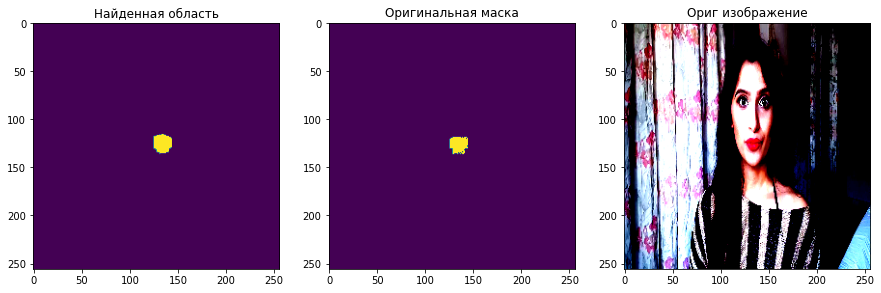

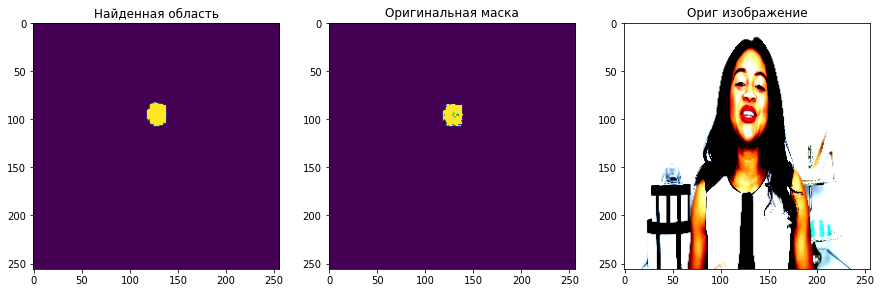

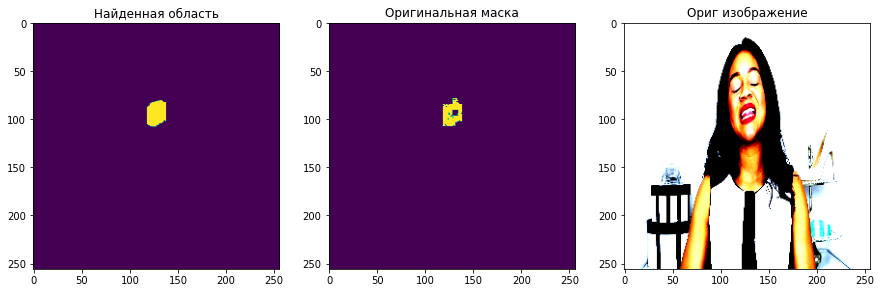

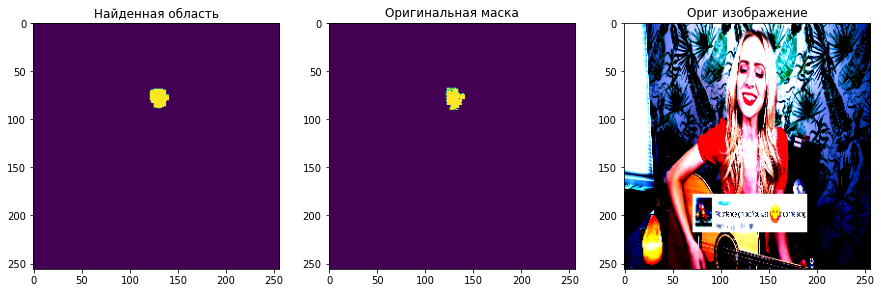

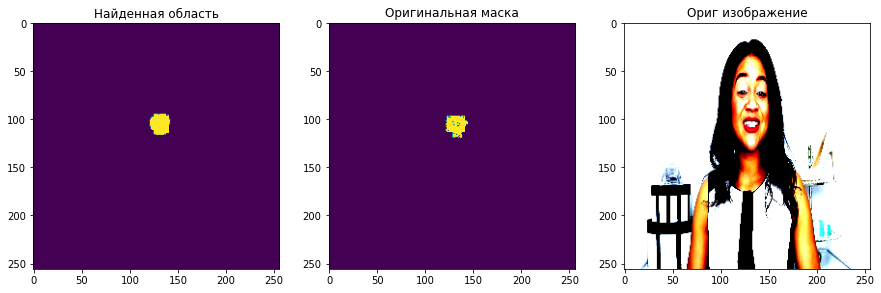

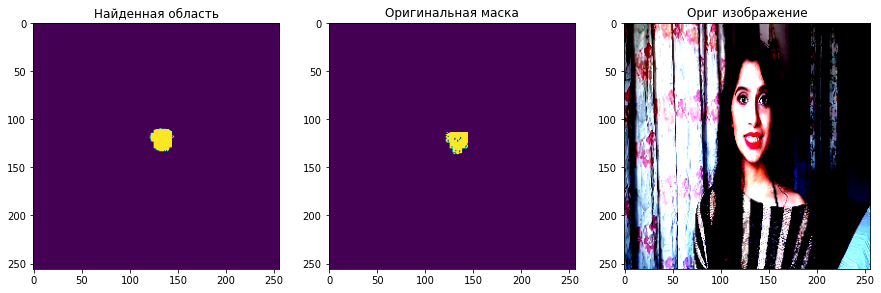

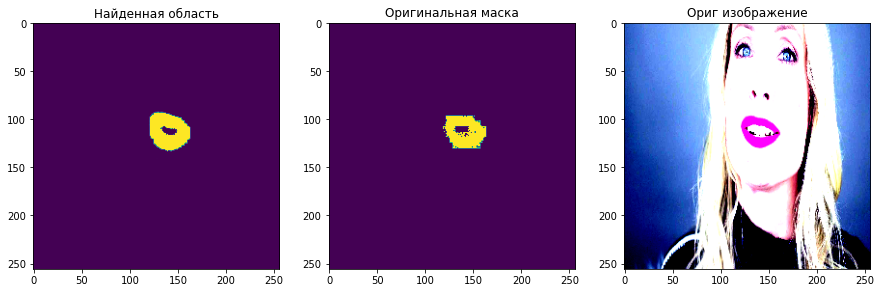

In [158]:
for i, (images, labels) in enumerate(test_dataloader, 0):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    outputs = segmodel(images)
    f, ax = plt.subplots(1, 3, figsize=(15, 6))

    for j in range(0, 4):
        ax[0].imshow(outputs.squeeze().detach().to(DEVICE).numpy()[j, 1, :, :])
        ax[0].set_title('Найденная область')
        ax[1].imshow(labels.detach().to(DEVICE).numpy()[j, 1, :, :])
        ax[1].set_title('Оригинальная маска')

        original = images[j].to(DEVICE)
        original = original.permute(1, 2, 0)
        original = original.numpy()
        original = np.clip(original, 0, 1)

        ax[2].imshow(original)
        ax[2].set_title('Ориг изображение')
        plt.show()
    if i > 5:
        break
